#This Project is developed to take a wav file of a single voice of music and get the musical pitch at any time frame.

Imports:

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import statistics
import random
import math
import librosa

Name of User (used in application)

In [18]:
userId = 'user'

Load audio file (only accepts .wav file)

In [19]:
originalFileLoc = "./data/raw/testAudioVoice.wav"
x, sr = librosa.load(originalFileLoc)
audioDuration = librosa.get_duration(y=x, sr=sr)

Set values

In [20]:
defaultDecimalRate = 5
defaultLoweringRate = 3
defaultDurationTime = 0.05
defaultMinDist = 0.05

pitchToLetter = {
    0: 'C',
    1: 'C#',
    2: 'D',
    3: 'D#',
    4: 'E',
    5: 'F',
    6: 'F#',
    7: 'G',
    8: 'G#',
    9: 'A',
    10: 'A#',
    11: 'B'
}

pitches = {0: 65.406}
currentPitch = 0
while currentPitch <= 71:
    prevPitch = pitches[currentPitch]
    currentPitch += 1
    pitches[currentPitch] = prevPitch * (2 ** (1/12))

Create Functions

In [21]:
def is_close(a, b, tolerance=1e-2):
       return abs(a - b) < tolerance

def lowerRate(lst, rte, decimalRate):
    """(List of signal, updated rate (x))
    Used to lower bitrate by a factor of x to fix fuzz"""
    retList = []
    for i in range(int(len(lst) / rte) - 1):
        includedIndices = [lst[i * rte]]
        for j in range(rte):
            includedIndices.append(lst[(i * rte) + j + 1])
        retList.append(round(statistics.median(includedIndices),decimalRate))
    return (retList)

Pitch Analyzer Class:

In [22]:
class PitchAnalyzer:
    def __init__(self, filename, decimalRate = defaultDecimalRate, loweringRate = defaultLoweringRate, minDist = defaultMinDist, durationTime = defaultDurationTime):
        self.decimalRate = decimalRate
        self.loweringRate = loweringRate
        self.minDist = minDist
        self.durationTime = durationTime
        
        spf = wave.open(filename, "r")
        signal = spf.readframes(-1)
        signal = np.frombuffer(signal, np.int16)
        
        frameRate = spf.getframerate()
        
        timeList = []
        
        newDuration = (len(signal) / frameRate)
        if is_close(newDuration / 2, audioDuration): 
            for i in range(len(signal)):
                timeList.append(round((i / 2) / frameRate,self.decimalRate))
                
        else:
            for i in range(len(signal)):
                timeList.append(round(i / frameRate,self.decimalRate))
                

        
        
        
            
        if self.loweringRate != 1:
            signal = lowerRate(signal, self.loweringRate, self.decimalRate)
            timeList = lowerRate(timeList, self.loweringRate, self.decimalRate)
            
            
        self.signal = signal.copy()
        self.timeList = timeList.copy()
        self.length = timeList[-1]
        
    def createWavGraph(self, fileLoc):
        
        plt.figure(1)
        plt.title("Musical Plot of: " + fileLoc)
        plt.plot(self.timeList, self.signal)
        
        # for i in (changesOfDerivative):
        #     plt.plot(timeList[i], signal[i], 'ro')
        #     plt.annotate(f'({round(timeList[i],4)})', (timeList[i], signal[i]), textcoords="offset points", xytext=(0, 10), ha='center')
        # for i in (antiPeaks):
        #     plt.plot(timeList[i], signal[i], 'bo')
        
        plt.savefig(fileLoc)
        plt.show()
        plt.close()

        # plt.savefig('my_plot.png')
    
    def graphPitches(self, fileLoc):
        retFreqList = []
        retTimeList = []
        i = 0
        
        while i < self.length - 0.1:
            try:
                retFreqList.append(self.getPitchAtTime(i))
                retTimeList.append(i)
            except Exception as err:
                # print(err)
                pass
            i += self.durationTime
            
        specTimeLoc = retTimeList[random.randint(0,len(retTimeList) - 1)]
        
        self.getPitchAtTime(specTimeLoc, fileName = ("./data/processed/plotPartial" + userId + ".png"))
        self.createWavGraph(fileLoc = ("./data/processed/plotFull" + userId + ".png"))
        
            
        avgVal = statistics.median(retFreqList)
        removeIndexes = []
        for i in range(len(retFreqList)):
            currentVal = retFreqList[i]
            if not (currentVal) < (avgVal * (1 + (self.minDist * 10))) and (currentVal) > (avgVal * (1 - (self.minDist * 0.1))):
                removeIndexes.append(i)
                
        retFreqList = [item for index, item in enumerate(retFreqList) if index not in removeIndexes]
        retTimeList = [item for index, item in enumerate(retTimeList) if index not in removeIndexes]
        
        retFreqList = lowerRate(retFreqList, 5, self.decimalRate)
        retTimeList = lowerRate(retTimeList, 5, self.decimalRate)
            
        plt.figure(1)
        plt.title("Frequency (hz) over time (seconds)" )
        plt.plot(retTimeList, retFreqList)
        
        # for i in (changesOfDerivative):
        #     plt.plot(timeList[i], signal[i], 'ro')
        #     plt.annotate(f'({round(timeList[i],4)})', (timeList[i], signal[i]), textcoords="offset points", xytext=(0, 10), ha='center')
        # for i in (antiPeaks):
        #     plt.plot(timeList[i], signal[i], 'bo')
        
        plt.savefig(fileLoc)
        plt.show()
        plt.close()
            
        
        
        
         


    def getPitchAtTime(self, startTime, fileName = False, durationTime = False):
        """(Start time in seconds, End time in seconds, name of .wav file)
        Returns most common frequency at the listed time"""
        
        if (durationTime == False):
            durationTime = self.durationTime
        
        decimalRate = self.decimalRate
        minDist = self.minDist
        
        startTime = round(startTime, decimalRate)
        durationTime = round(durationTime, decimalRate)
        
        signal = self.signal.copy()
        timeList = self.timeList.copy()
        

        while(startTime not in timeList):
            startTime = round(startTime + 1 / 10 ** decimalRate,decimalRate)
        startIndex = int(timeList.index(startTime))
        while (startTime + durationTime not in timeList):
            durationTime += 1 / 10 ** decimalRate
            durationTime = round(durationTime, decimalRate)
        endIndex = int(timeList.index(startTime + durationTime))


        
        signal = signal[startIndex:endIndex]
        timeList = timeList[startIndex:endIndex]
        
        signalDerivative = []

        for i in range(len(signal) - 1):
            topNum = signal[i + 1]
            botNum = signal[i]
            signalDerivative.append(topNum - botNum)
            
        prevVal = signalDerivative[0]
        changesOfDerivative = []
        antiPeaks = []
        for i in range(len(signalDerivative) - 1):
            currentVal = signalDerivative[i + 1]
            
            if currentVal * prevVal < 0:
                changesOfDerivative.append(i + 1)
                if currentVal > 0:
                    if len(antiPeaks) == 0:
                        antiPeaks.append(i+1)
                    else:
                        avgPeak = 0
                        for j in antiPeaks:
                            avgPeak += signal[j]
                        avgPeak /= len(antiPeaks)
                        if (signal[i + 1] <= (avgPeak * (1-minDist))):
                            antiPeaks.append(i+1)
                            
            prevVal = currentVal
        
        peakVals = []
        for i in antiPeaks:
            peakVals.append(signal[i])

        avgPeak = statistics.median(peakVals)
        removeIndexes = []
        for i in range(len(antiPeaks)):
            if not ((signal[antiPeaks[i]]) < (avgPeak * (1 - minDist)) and (signal[antiPeaks[i]]) > (avgPeak * (1 + minDist))):
                removeIndexes.append(i)
                
        antiPeaks = [item for index, item in enumerate(antiPeaks) if index not in removeIndexes]

        frequencies = []
        
        for i in range(len(antiPeaks) - 1):
            topNum = timeList[antiPeaks[i + 1]]
            botNum = timeList[antiPeaks[i]]
            if topNum != botNum:
                frequencies.append(1/(topNum - botNum))
            
        avgFreq = statistics.median(frequencies)
        
        if (fileName != False):
        
            plt.figure(1)
            plt.title("Musical Plot of: " + fileName)
            plt.plot(timeList, signal)
            for i in (changesOfDerivative):
                plt.plot(timeList[i], signal[i], 'ro')
                plt.annotate(f'({round(timeList[i],4)})', (timeList[i], signal[i]), textcoords="offset points", xytext=(0, 10), ha='center')
            for i in (antiPeaks):
                plt.plot(timeList[i], signal[i], 'bo')

            plt.savefig(fileName) 
            plt.show()
            plt.close()
        
        return(avgFreq)

Create analyzer

In [23]:
thisAnalyzer = PitchAnalyzer(originalFileLoc)

Graph all pitches

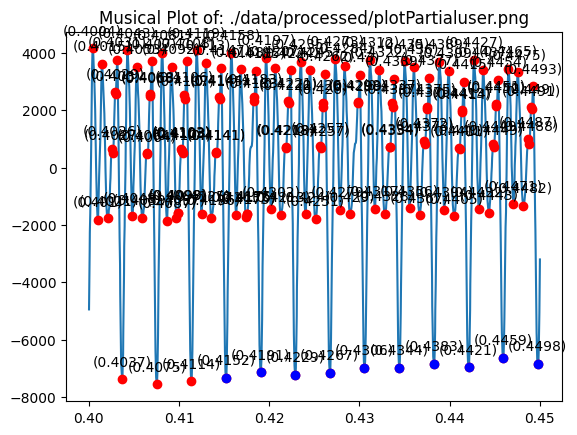

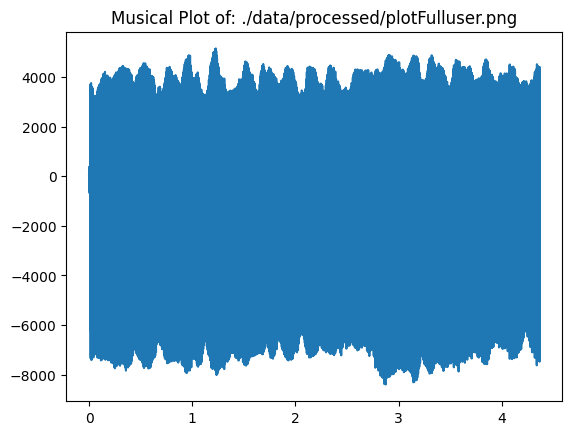

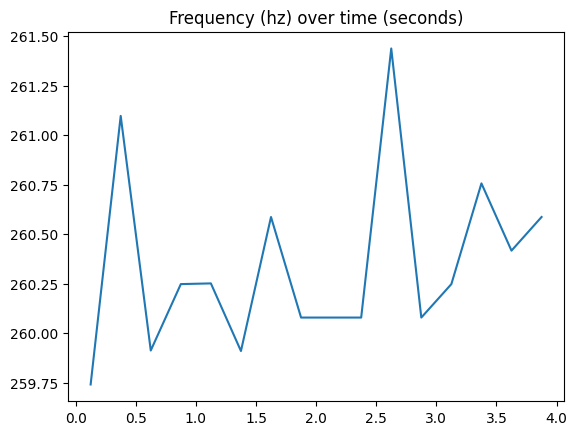

In [24]:
thisAnalyzer.graphPitches("./data/processed/pitchesPlotFull" + userId + ".png")